# (DACON) 신용카드 사용자 연체 예측 AI 경진대회 

Link : https://www.dacon.io/competitions/official/235713/talkboard/402821/

### About Data

- index

- gender: 성별

- car: 차량 소유 여부

- reality: 부동산 소유 여부

- child_num: 자녀 수

- income_total: 연간 소득

- income_type: 소득 분류

- edu_type: 교육 수준

- family_type: 결혼 여부

- house_type: 생활 방식

- DAYS_BIRTH: 출생일

- DAYS_EMPLOYED: 업무 시작일

- FLAG_MOBIL: 핸드폰 소유 여부

- work_phone: 업무용 전화 소유 여부

- phone: 전화 소유 여부

- email: 이메일 소유 여부

- occyp_type: 직업 유형

- family_size: 가족 규모

- begin_month: 신용카드 발급 월

- credit: 사용자의 신용카드 대금 연체를 기준의 신용도

## Loading packages and Datasets

In [1]:
import warnings
warnings.filterwarnings('ignore')
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
import random
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.impute import SimpleImputer
from collections import Counter

# model
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression

sns.set_style('darkgrid')

In [2]:
# train
train = pd.read_csv('data/train.csv')
train_index = train['index']
train.drop('index', inplace = True, axis = 1)

# test
test = pd.read_csv('data/test.csv')
test_index = test['index']
test.drop('index', inplace = True, axis = 1)

In [3]:
train.fillna(np.NaN, inplace = True)
test.fillna(np.NaN, inplace = True)

submit = pd.read_csv('data/sample_submission.csv')

## Glimpse the data

In [4]:
train.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month,credit
0,F,N,N,0,202500.0,Commercial associate,Higher education,Married,Municipal apartment,-13899,-4709,1,0,0,0,NaN,2.0,-6.0,1.0
1,F,N,Y,1,247500.0,Commercial associate,Secondary / secondary special,Civil marriage,House / apartment,-11380,-1540,1,0,0,1,Laborers,3.0,-5.0,1.0
2,M,Y,Y,0,450000.0,Working,Higher education,Married,House / apartment,-19087,-4434,1,0,1,0,Managers,2.0,-22.0,2.0
3,F,N,Y,0,202500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-15088,-2092,1,0,1,0,Sales staff,2.0,-37.0,0.0
4,F,Y,Y,0,157500.0,State servant,Higher education,Married,House / apartment,-15037,-2105,1,0,0,0,Managers,2.0,-26.0,2.0


In [5]:
test.head()

,gender,car,reality,child_num,income_total,income_type,edu_type,family_type,house_type,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,occyp_type,family_size,begin_month
0,M,Y,N,0,112500.0,Pensioner,Secondary / secondary special,Civil marriage,House / apartment,-21990,365243,1,0,1,0,NaN,2.0,-60.0
1,F,N,Y,0,135000.0,State servant,Higher education,Married,House / apartment,-18964,-8671,1,0,1,0,Core staff,2.0,-36.0
2,F,N,Y,0,69372.0,Working,Secondary / secondary special,Married,House / apartment,-15887,-217,1,1,1,0,Laborers,2.0,-40.0
3,M,Y,N,0,112500.0,Commercial associate,Secondary / secondary special,Married,House / apartment,-19270,-2531,1,1,0,0,Drivers,2.0,-41.0
4,F,Y,Y,0,225000.0,State servant,Higher education,Married,House / apartment,-17822,-9385,1,1,0,0,Managers,2.0,-8.0


In [6]:
train.describe()

,child_num,income_total,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,work_phone,phone,email,family_size,begin_month,credit
count,26457.000000,2.645700e+04,26457.000000,26457.000000,26457.0,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000,26457.000000
mean,0.428658,1.873065e+05,-15958.053899,59068.750728,1.0,0.224742,0.294251,0.091280,2.196848,-26.123294,1.519560
std,0.747326,1.018784e+05,4201.589022,137475.427503,0.0,0.417420,0.455714,0.288013,0.916717,16.559550,0.702283
min,0.000000,2.700000e+04,-25152.000000,-15713.000000,1.0,0.000000,0.000000,0.000000,1.000000,-60.000000,0.000000
25%,0.000000,1.215000e+05,-19431.000000,-3153.000000,1.0,0.000000,0.000000,0.000000,2.000000,-39.000000,1.000000
50%,0.000000,1.575000e+05,-15547.000000,-1539.000000,1.0,0.000000,0.000000,0.000000,2.000000,-24.000000,2.000000
75%,1.000000,2.250000e+05,-12446.000000,-407.000000,1.0,0.000000,1.000000,0.000000,3.000000,-12.000000,2.000000
max,19.000000,1.575000e+06,-7705.000000,365243.000000,1.0,1.000000,1.000000,1.000000,20.000000,0.000000,2.000000


In [7]:
print('Count of Types(train):\n' ,train.dtypes.value_counts())

null_count = train.isnull().sum()
sorted_null_count = null_count[null_count > 0].sort_values(ascending = False)
print()
print('NaN value: \n', sorted_null_count)

Count of Types(train):
 object     8
int64      7
float64    4
dtype: int64

NaN value: 
 occyp_type    8171
dtype: int64


In [8]:
print('Count of Types(test):\n' ,test.dtypes.value_counts())

null_count = test.isnull().sum()
sorted_null_count = null_count[null_count > 0].sort_values(ascending = False)
print()
print('NaN value: \n', sorted_null_count)

Count of Types(test):
 object     8
int64      7
float64    3
dtype: int64

NaN value: 
 occyp_type    3152
dtype: int64


In [9]:
y_target = train['credit']

y_target.value_counts(1)

2.0    0.641343
1.0    0.236875
0.0    0.121783
Name: credit, dtype: float64

<AxesSubplot:>

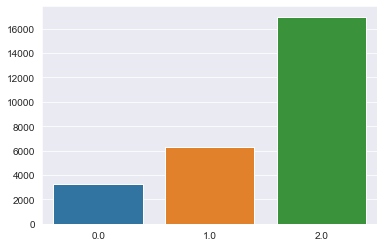

In [10]:
sns.barplot(x = y_target.value_counts().index ,y = y_target.value_counts().values)

2 > 1 > 0순으로 많다. 데이콘의 discussion을 보니 Credit이 높으면 신용도가 낮은 것을 의미한다.

### Missing Value

In [11]:
train.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       8171
family_size         0
begin_month         0
credit              0
dtype: int64

occyp_type(직업 유형)에 8171개의 결측값 존재함. EDA를 통해 결측치가 다른 값으로 입력되어있지않은지 확인해볼 필요가 있다.

In [12]:
test.isnull().sum()

gender              0
car                 0
reality             0
child_num           0
income_total        0
income_type         0
edu_type            0
family_type         0
house_type          0
DAYS_BIRTH          0
DAYS_EMPLOYED       0
FLAG_MOBIL          0
work_phone          0
phone               0
email               0
occyp_type       3152
family_size         0
begin_month         0
dtype: int64

In [13]:
train.select_dtypes('object').apply(pd.Series.nunique, axis = 0)

gender          2
car             2
reality         2
income_type     5
edu_type        5
family_type     5
house_type      6
occyp_type     18
dtype: int64

gender, car, reality는 2개의 유니크한 값을 가지지만 다른 변수들은 2개 이상의 유니크한 값을 가진다. 

특히 occyp_type은 18개로 많은 값을 가지므로 label encoding보다는 One Hot encoding이 좋을 것이다.

2개는 label encoding 방법을 채택하고, 2개 초과는 one-hot encoding 방법을 채택함.

### Make a derived variable

In [14]:
# 일한 기간 / 나이
train['EMPLOYED_BIRTH_RATIO'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['EMPLOYED_BIRTH_RATIO'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']

# 소득 / 일한 기간
train['INCOME_EMPLOYED_RATIO'] = train['income_total'] / train['DAYS_EMPLOYED']
test['INCOME_EMPLOYED_RATIO'] = test['income_total'] / test['DAYS_EMPLOYED']

# 소득 / 나이
train['INCOME_BIRTH_RATIO'] = train['income_total'] / train['DAYS_BIRTH']
test['INCOME_BIRTH_RATIO'] = test['income_total'] / test['DAYS_BIRTH']

# 소득 / 가족의 수 : 가족 구성원의 인당 소득
train['CNT_FAM_INCOME_RATIO'] = train['income_total'] / train['family_size']
test['CNT_FAM_INCOME_RATIO'] = test['income_total'] / test['family_size']

# 카드를 발급 받은 시점의 나이
train['DAYS_BIRTH_CARD'] = train['DAYS_BIRTH']  - train['begin_month']
test['DAYS_BIRTH_CARD'] = test['DAYS_BIRTH'] - test['begin_month']

### Encoding

In [15]:
# Label Encoding
le = LabelEncoder()
le_count = 0

for col in train:
    if train[col].dtype == 'object':
        # unique <= 2
        if len(list(train[col].unique())) <= 2:
            le.fit(train[col])
            train[col] = le.transform(train[col])
            test[col] = le.transform(test[col])
            
            le_count += 1
print('%d columns were label encoded.' % le_count)

3 columns were label encoded.


In [16]:
# One-Hot Encoding
train = pd.get_dummies(train)
test = pd.get_dummies(test)

print('Train Features shape: ', train.shape)
print('Test Features shape: ', test.shape)

Train Features shape:  (26457, 58)
Test Features shape:  (10000, 57)


In [17]:
train['DAYS_BIRTH'] = train['DAYS_BIRTH'] / -365
test['DAYS_BIRTH'] = test['DAYS_BIRTH'] / -365

In [18]:
train['begin_month'] = train['begin_month'] / -12
test['begin_month'] = test['begin_month'] / -12

-12로 나눈 후, 점수가 나아지는지는 확인해봐야할 듯

## Modeling

In [19]:
skf = StratifiedKFold(n_splits = 5, shuffle=True, random_state=42)
folds=[]
for train_idx, valid_idx in skf.split(train, train['credit']):
    folds.append((train_idx, valid_idx))

In [20]:
random.seed(42)
lgb_models={}
for fold in range(5):
    print(f'===================================={fold+1}============================================')
    train_idx, valid_idx = folds[fold]
    X_train, X_valid, y_train, y_valid = train.drop(['credit'],axis=1).iloc[train_idx].values, train.drop(['credit'],axis=1).iloc[valid_idx].values,\
                                         train['credit'][train_idx].values, train['credit'][valid_idx].values 
    lgb = LGBMClassifier(n_estimators=1000, colsample_bytree=0.6, max_depth= -1, learning_rate=0.1)
    lgb.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds = 200,
           verbose=100,)
    lgb_models[fold]=lgb
    print(f'================================================================================\n\n')

====================================1============================================
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 0.641348	valid_1's multi_logloss: 0.740124
[200]	training's multi_logloss: 0.553966	valid_1's multi_logloss: 0.719104
[300]	training's multi_logloss: 0.491174	valid_1's multi_logloss: 0.709269
[400]	training's multi_logloss: 0.44026	valid_1's multi_logloss: 0.707455
[500]	training's multi_logloss: 0.399058	valid_1's multi_logloss: 0.708716
[600]	training's multi_logloss: 0.363304	valid_1's multi_logloss: 0.712136
Early stopping, best iteration is:
[424]	training's multi_logloss: 0.429949	valid_1's multi_logloss: 0.706993


====================================2============================================
Training until validation scores don't improve for 200 rounds
[100]	training's multi_logloss: 0.638217	valid_1's multi_logloss: 0.755167
[200]	training's multi_logloss: 0.550166	valid_1's multi_logloss: 0.734538
[

              precision    recall  f1-score   support

         0.0       0.58      0.17      0.26       644
         1.0       0.70      0.37      0.49      1253
         2.0       0.73      0.95      0.82      3394

    accuracy                           0.72      5291
   macro avg       0.67      0.50      0.52      5291
weighted avg       0.70      0.72      0.67      5291



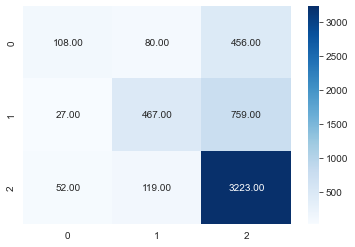

In [21]:
y_predict = lgb.predict(X_valid)

matrix = pd.DataFrame(confusion_matrix(y_valid, y_predict))
sns.heatmap(matrix, annot = True, cmap = 'Blues', fmt = '.2f')
print(classification_report(y_valid, y_predict))

In [22]:
pd.Series(lgb.feature_importances_, index = test.columns).sort_values(ascending = False)

begin_month                               3586
INCOME_BIRTH_RATIO                        3538
EMPLOYED_BIRTH_RATIO                      3168
INCOME_EMPLOYED_RATIO                     3113
DAYS_BIRTH                                2837
DAYS_BIRTH_CARD                           2779
CNT_FAM_INCOME_RATIO                      2539
DAYS_EMPLOYED                             2432
income_total                              2044
car                                        483
phone                                      427
reality                                    409
family_size                                360
work_phone                                 330
child_num                                  324
gender                                     324
edu_type_Secondary / secondary special     319
edu_type_Higher education                  313
income_type_Working                        309
family_type_Married                        291
occyp_type_Laborers                        231
income_type_C

### Submit

In [23]:
submit.iloc[:,1:]=0
for fold in range(5):
    submit.iloc[:,1:] += lgb_models[fold].predict_proba(test)/5

In [24]:
submit.to_csv('20210505_test_submit_ensemble(feature_engineering2).csv', index=False)

In [25]:
submit.head(6) # 0.71178

,index,0,1,2
0,26457,0.057470,0.077125,0.865405
1,26458,0.288925,0.207995,0.503079
2,26459,0.055000,0.075019,0.869981
3,26460,0.097096,0.133845,0.769059
4,26461,0.131185,0.184398,0.684416
5,26462,0.056338,0.122149,0.821513


- Feature Engineering 후 : 0.7152755023 -> 0.71178 / 0.0034955023 감소함
- hyper parameter 후 : 0.71178 -> 0.7103176289